# Ensemble-FF-Fit - ReaxFF Ensemble Fitting

In this tutorial, we will demonstrate how we can make use of the [Ensemble-FF-Fit](https://github.com/Q-CAD/Ensemble-FF-Fit) and [MatEnsemble](https://github.com/Q-CAD/MatEnsemble) packages to iteratively fit and evaluate many Bi-Se ReaxFF reactive force fields in parallel. 

**Note:** Some of the code blocks have been commented out. This indicates that certain files might already be present in the ```examples``` directory for convenience. 

This notebook was written by Ryan Morelock.

## Outline of this notebook:

1. **Install Ensemble-FF-Fit** and required dependencies into a conda environment
2. **Generate modified Bi-Se structures** from Materials Project queries
3. **Perform DFT calculations** on these modified structures using [vaspFlux](https://code.ornl.gov/rym/vaspflux)
4. **Parse ReaxFF compatible input files** from DFT outputs using [parse2fit](https://code.ornl.gov/rym/parse2fit)
5. **Fit an ensemble of ReaxFF force fields** using [JAX-ReaxFF](https://github.com/cagrikymk/JAX-ReaxFF)
6. **Run Bi-Se melting simulations** with ReaxFF+LAMMPs, view with [vdW_Structures](https://code.ornl.gov/rym/vdw_structures)
7. **Calculate MD single-point energies** for the force field ensemble
8. **Determine the Ensemble Standard Deviation** for the collection of MD images
9. **Calculate the DFT single-point energies** on MD images where the ensemble standard deviation is largest
10. **Determine the Best Force Field** based on the MD trajectories
11. **Determine New Structures** to include in the next rounds of fitting

## Outline of subdirectories:
1. **DFT:** Contains
    1. Input yamls for structure generation executables
    2. parse2fit yamls to direct parsing
    3. vaspFlux inputs for DFT input generation, and
    4. a submission script to run vaspFlux on Perlmutter
2. **ForceFields:** Contains
    1. a submission script to run Jax-ReaxFF fitting through the MatEnsemble framework on Perlmutter
    2. ```inputs_directory``` containing Jax-ReaxFF force field fitting inputs
    3. ```run_directory``` containing already performed Jax-ReaxFF runs for demo purposes
3. **MD:** Contains
    1. ```md_runs``` with different melt trajectories for starting Bi-Se compositional system structures.
    2. ```single_point_runs``` used to calculate single point energies across different force fields in the precomputed ensemble.
    3. ```mace_comparison``` directory where we compute single points along our mace comparison trajectory for the starting force field and force fields refit during ensemble fitting. 

## 1. Ensemble-FF-Fit Installation

[MatEnsemble](https://github.com/Q-CAD/MatEnsemble) is based on the [Flux](https://flux-framework.readthedocs.io/en/latest/guides/learning_guide.html) framework to maximize resource usage. 

Flux on Perlmutter has currently been installed via [Spack](https://spack.io), allowing application-specific, e.g., LAMMPs or Jax-ReaxFF, Python conda environments to be loaded. 

Click the [Ensemble-FF-Fit](https://github.com/Q-CAD/Ensemble-FF-Fit) link for complete details on how to 1. build a Spack with Flux and 2. create conda environments compatible with this spack. These conda environments will need to be loaded within the job submission scripts used by this notebook (see examples in Ensemble-FF-Fit). 

For the present notebook, we only need to install the default Ensemble-FF-Fit environment and parse2fit, but I will load a pre-built conda environment with vaspFlux also installed.  

First, we'll need to ensure that this Ensemble-FF-Fit conda environment is added to Jupyter as a loadable kernel. If Ensemble-FF-Fit has not been added, first active the environment in a terminal window:

```conda activate ensemblefffit```

or your conda environment alias. Next, make the environment loadable as a Jupyter kernel:

```python -m ipykernel install --user --name ensemblefffit --display-name "Ensemble-FF-Fit"```

You should now be able to load the Ensemble-FF-Fit kernel and see it displayed in the upper right hand corner.

Finally, we need to prepend ensemblefffit's bin to the PATH so we can use the Python executables. 

In [2]:
import sys, os, shutil, subprocess, glob

In [2]:
def remove_path(path):
    if os.path.exists(path):
        if os.path.isdir(path):
            shutil.rmtree(path)
            return 
        os.remove(path)
    return 

In [3]:
env_bin = os.path.dirname(sys.executable)
os.environ["PATH"] = env_bin + os.pathsep + os.environ.get("PATH", "")

print("mp_query executable location:", shutil.which("mp_query"))

mp_query executable location: /global/homes/r/rym/.conda/envs/ensemblefffit/bin/mp_query


## 2. Generate DFT structures

### a. Query Materials Project Bulk Structures

Ensemble-FF-Fit has several command line executables installed that can be used to generate structures for DFT runs. These executables work on 'POSCAR' files, formatted for VASP DFT inputs. 

We will begin by using the ```mp_query``` executable and the direction ```VASP/yamls/MP/Bi-Se.yml``` file to query structure objects from the Bi-Se compositional system from the [Materials Project](https://next-gen.materialsproject.org) and generate POSCAR files.  

In [4]:
path_to_bulk_poscars = os.path.join(os.getcwd(), 'DFT/structures/bulk')
#remove_path(path_to_bulk_poscars)
path_to_mp_yaml = os.path.join(os.getcwd(), 'DFT/yamls/MP/Bi-Se.yml')

#subprocess.run(["mp_query",
#                    "--poscars_directory", path_to_bulk_poscars,
#                    "--max_atoms", "20",
#                    "--MP_yaml", path_to_mp_yaml], stdout=subprocess.DEVNULL)

### b. Generating defect structures
Next, let's copy the 'bulk' directory tree to 'defect' and generate a collection of defect structures. **Note**: the larger the structures, the longer it takes to generate defects. 

In [5]:
path_to_defect_poscars = os.path.join(os.getcwd(), 'DFT/structures/defects')
#remove_path(path_to_defect_poscars)
#shutil.copytree(path_to_bulk_poscars, path_to_defect_poscars)

#subprocess.run(["generate_defects",
#                    "--poscars_directory", path_to_defect_poscars,
#                    "--vacancy", "--antisite", "--interstitial", "--substitution"], stdout=subprocess.DEVNULL)

### c. Rescaling structures 
We can run ```generate_EoS``` on the defect structure directory to rescale them. 

In [6]:
#subprocess.run(["generate_EoS",
#                    "--poscars_directory", path_to_defect_poscars], stdout=subprocess.DEVNULL)

These executables provide convenient ways to rapidly generate many different structures for DFT optimization. 

## 3. Perform DFT Calculations

We will start by generating a small collection of structures to run DFT calculations on. 

In [3]:
path_to_dft_poscars = os.path.join(os.getcwd(), 'DFT/valdiation/Bi2Se3')
#remove_path(path_to_dft_poscars)
path_to_dft_yaml = os.path.join(os.getcwd(), 'DFT/yamls/MP_DFT/Bi2Se3.yml')

#subprocess.run(["mp_query",
#                    "--poscars_directory", path_to_dft_poscars,
#                    "--max_atoms", "100",
#                    "--MP_yaml", path_to_dft_yaml], stdout=subprocess.DEVNULL)

Let's run ```generate_vaspflux``` on these poscars to create their VASP input files and single-job submission scripts. We'll need to have installed vaspFlux in the environment and set up its config.yml before performing these commands, see [vaspFlux](https://code.ornl.gov/rym/vaspflux).

In [4]:
vasp_submission_template = os.path.join(os.getcwd(), 'DFT/validation/inputs/perlmutter_vasp_gpu.sh')
vasp_input_yaml = os.path.join(os.getcwd(), 'DFT/validation/inputs/vdW_single_point.yml')
#subprocess.run(["generate_vaspflux",
#                    "--poscars_directory", path_to_dft_poscars,
#                    "--vasp_yaml", vasp_input_yaml,
#                    "--vasp_submission", vasp_submission_template], stdout=subprocess.DEVNULL)

# Now list the subdirectories with 'POSCAR' files
#for root, _, _ in os.walk(path_to_dft_poscars):
#    if os.path.exists(os.path.join(root, 'POSCAR')):
#        print(f'Root: {root}, files: {os.listdir(root)}')

We can submit these as individual files using the ```submit_vaspFlux``` command, but with MatEnsemble we can do better! Let's submit the ```submit_matsemble_vaspFlux_gpu.sh``` file, which sets the srun options, loads the Spack, Conda environment, necessary modules, and chains together the file generation and submission logic to run VASP single point calculations. 

We'll submit this using the ```MatEnsemble_submission_wrapper```, which allows us to monitor the job's status while it's in the queue. This wrapper can accept arguments to resubmit the jobs if necessary, though this won't be an issue for our small single-point calculations.  

In [9]:
from EnsembleFFFit.matensemble.in_queue import MatEnsemble_submission_wrapper

In [5]:
vasp_dir = os.path.join(os.getcwd(), 'DFT/validation') # path to vasp_submission script
vasp_submission = 'submit_matsemble_vaspFlux_gpu.sh' # name of vasp_submission SLURM script
#MatEnsemble_submission_wrapper(workdir=vasp_dir, 
#                               submission_file=vasp_submission)

We now have a collection of converged DFT runs that we can parse for force field fitting!

## 4. Parse ReaxFF Compatible Input Files

Let's generate ReaxFF compatible trainset.in and geo files using the ```parser.yml``` file in the ```ForceFields``` directory. This will write ```trainset.in``` and ```geo``` files to ```/pscratch/sd/r/rym/EnsembleFFFit/ForceFields/inputs_directory```. 

**Note:** JaxReaxFF uses relative energies, so all energies have been normalized against vdW-layered Bi2Se3, which has the Materials Project ID mp-541837. You can see the tags which set this in the .yml file. 

In [11]:
parse2fit_yaml_path = os.path.join(os.getcwd(), 'ForceFields/yamls/parsing/parse2fit.yml')
#subprocess.run(["generate_parse2fit", parse2fit_yaml_path])

Let's move the written files to ```inputs_directory``` and rename them ```validset.in``` and ```valid_geo```. These will be our validation set for JaxReaxFF training. 

In [12]:
#shutil.move(os.path.join(os.getcwd(), 'ForceFields/inputs_directory/reaxff_run_0/trainset.in'), 
#            os.path.join(os.getcwd(), 'ForceFields/inputs_directory/validset.in'))
#shutil.move(os.path.join(os.getcwd(), 'ForceFields/inputs_directory/reaxff_run_0/geo'), 
#            os.path.join(os.getcwd(), 'ForceFields/inputs_directory/valid_geo'))
#remove_path(os.path.join(os.getcwd(), 'ForceFields/inputs_directory/reaxff_run_0'))

## 5. Fit an Ensemble of ReaxFF Force Fields

Now we can perform fitting! For simplicity, we will use existing trainset.in (total energies) and geo files that come from previous DFT runs, generated from MP inputs with a variety of defects and rescalings. The trainset.in files have different objective function weights (varied with ```parse2fit```) which should allow us to better sample the parameter space. 

In [13]:
jaxreaxff_dir = os.path.join(os.getcwd(), 'ForceFields') # path to vasp_submission script
jaxreaxff_submission = 'jaxreaxff_matensemble.sh' # name of vasp_submission SLURM script

In [14]:
#MatEnsemble_submission_wrapper(workdir=jaxreaxff_dir, 
#                               submission_file=jaxreaxff_submission)

Now that our fitting has finished, let's write a simple function to select our force field for MD fitting. We'll balance the training data objective function (which differ based on the training data used) with the validation data objective function (which is the same across all fits) to select our force field for MD testing; feel free to change the weighting as you see fit. 

In [15]:
import glob
import re
from pathlib import Path

In [16]:
def select_FF(path, training_weight=0.9, validation_weight=0.1):
    '''Chooses a force field based on a weighted combination of 
       training and validation objective functions'''
    best_path, best_total = None, None
    for root, _, _ in os.walk(path):
        output_paths = glob.glob(os.path.join(root, 'new_FF*.txt'))
        if output_paths: 
            filenames = [Path(op).name for op in output_paths]
            splits = [f.replace('.', '_').split('_') for f in filenames]
            for i, split in enumerate(splits):
                split_total = training_weight * float(split[3]) + validation_weight * float(split[6])
                if not best_total or split_total < best_total:
                    best_path = os.path.join(root, split[0] + '_' + split[1] + '_' + split[2] + '_' + split[3])
                    best_total = split_total
                
    return best_path

In [17]:
jaxreaxff_run_path = os.path.join(jaxreaxff_dir, 'run_directory')
best_FF_path = select_FF(jaxreaxff_run_path)

We can now copy our best force field to our MD directory for our melting runs, and all of our force fields to directory where we will evaluate single point energies.  

In [18]:
# First the best file
write_best_FF_path = os.path.join(os.getcwd(), 'MD/md_runs/run_directory', Path(best_FF_path).name)
#os.makedirs(write_best_FF_path, exist_ok=True)
#shutil.copy(best_FF_path, os.path.join(write_best_FF_path, 'ffield'))

In [19]:
# Then all files
ffield_pattern = r"^new_FF_([\d_]+)$" # Regex pattern for output JaxReaxFF files
write_all_FF_path = os.path.join(os.getcwd(), 'MD/single_point_runs/run_directory')
#subprocess.run(["copy_by_pattern",
#                    "--source_directory", jaxreaxff_run_path,
#                    "--target_directory", write_all_FF_path,
#                    "--target_name", 'ffield', 
#                    "--pattern", ffield_pattern], stdout=subprocess.DEVNULL)

## 6. Run Bi-Se melting simulations

The next step is to evaluate our force fields' energetics on dynamic MD runs rather than just static DFT runs. I'll run multiple MD trajectories with our chosen force field, which we believe will be the most performant based on its training and validation set error. 

In ```MD/md_runs/inputs_directory``` I've added sub-directories with different bulk structure supercells to melt: orthorhombic, cubic and layered Bi2Se3, and layered Bi4Se3. Feel free to modify the input lammps files to accommodate different MD recipes. 

Let's first use a viewer installed in the [vdW_Structures](https://code.ornl.gov/rym/vdw_structures) package to look at the MD structure files to be run. 

In [20]:
from vdW_structures.viewer import view_structure
from pymatgen.io.ase import AseAtomsAdaptor
from ase.io import read

In [21]:
color_map = {"Bi": "orange", "Se": "purple"}
aaa = AseAtomsAdaptor()

structure_to_view = aaa.get_structure(read(os.path.join(os.getcwd(), 'MD/md_runs/inputs_directory/Bi2Se3_layered/structure.lmp'), 
                                       format='lammps-data', atom_style='charge'))

view_structure(structure_to_view, color_map=color_map)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

If we're satisfied, let's now submit the MD runs. **NOTE:** ReaxFF on CPUs tends to run faster with more CPUs. We'll request 3 Perlmutter nodes (128 CPUs/apiece) for the MatEnsemble job, and set the ```--atoms_per_task``` flag to use all available resources. As a reminder, we can check how many resources will be requested with the ```--dry_run``` flag. 

In [22]:
md_dir = os.path.join(os.getcwd(), 'MD/md_runs') # path to vasp_submission script
md_submission = 'submit_matensemble_lammps_cpu.sh' # name of vasp_submission SLURM script
#MatEnsemble_submission_wrapper(workdir=md_dir, 
#                               submission_file=md_submission)

## 7. Calculate MD single-point energies

We have a collection of dump files when the MD runs have finished, for which we can compute single-point energies with our ensemble of fitted force fields. We'll convert the dump files back to lammps data files and move them to the ```MD/single_point_runs/inputs_directory```, which already has the required files and lammps MD recipes to perform single point calculations.  

In [23]:
# Convert all dump files from the MD trajectories to LAMMPs input files
dump_pattern = r"^dump_(\d+)\.dump$" # Regex pattern for output dump files
md_run_path = os.path.join(os.getcwd(), 'MD/md_runs/inputs_directory')
write_all_dump_path = os.path.join(os.getcwd(), 'MD/single_point_runs/inputs_directory')
#subprocess.run(["copy_by_pattern",
#                    "--source_directory", 'MD/md_runs/run_directory/',
#                    "--target_directory", 'MD/single_point_runs/inputs_directory/',
#                    "--target_name", 'structure.lmp', 
#                    "--pattern", dump_pattern, 
#                    "-nsdd", '1', 
#                    "--in_lammps", os.path.join(os.getcwd(), 'MD/md_runs/inputs_directory/in.matensemble')], 
#                    stdout=subprocess.DEVNULL)

Now, as before, we'll run the workflow through MatEnsemble, to calculate the single points on all of JaxReaxFF force fields we've fit. 

**Note:** We'll batch the single points for MatEnsemble to accelerate these calculations. This only initializes the LAMMPs python object once per MD trajectory, which avoids significant slowdown compared to running each single point as an individual job, and iterates over the structure.lmp files that we copied in the previous step, writing {image_number}.lammps files for each.

**Note:** Most of the time for this run is spent forming the run_path and arguments list for tasks to be submitted. 

In [24]:
md_sp_dir = os.path.join(os.getcwd(), 'MD/single_point_runs') # path to vasp_submission script
md_sp_submission = 'submit_matensemble_lammps_cpu.sh' # name of vasp_submission SLURM script
#MatEnsemble_submission_wrapper(workdir=md_sp_dir, 
#                               submission_file=md_sp_submission)

## 8. Determine the Ensemble Variance (Standard Deviation)

First, we'll write a function that map directories with LAMMPs log files and energies to dictionaries based on the MD images.

This will help us compare energies energies between force fields. 

In [25]:
import re
from pymatgen.io.lammps.outputs import parse_lammps_log

In [26]:
def nested_set(dct, keys, value):
    """
    In dct, create the nested path given by keys[0], keys[1], …, keys[-1],
    then assign dct[keys[0]][keys[1]]…[keys[-1]] = value.
    """
    if len(keys) == 1:
        # Base case: one key left → assign the value
        dct[keys[0]] = value
    else:
        # If the first key doesn't exist or isn't a dict, overwrite with a dict
        if keys[0] not in dct or not isinstance(dct[keys[0]], dict):
            dct[keys[0]] = {}
        # Recurse into the next level
        nested_set(dct[keys[0]], keys[1:], value)

In [27]:
def parse_single_points(path_to_images, 
                            log_index = 0,  
                            energy_label='PotEng'):
    data = {}
    for root, _, _ in os.walk(path_to_images):
        for output_path in glob.glob(os.path.join(root, '*.lammps')):
            log = parse_lammps_log(output_path)
            try:
                energy = float(log[log_index][energy_label][1]) # Error message written
            except:
                energy = float(log[log_index][energy_label][0]) # No error message written
            p = Path(output_path)
            image = int(re.findall(r'\d+', p.name)[0])
            md     = p.parent.name
            ffield = p.parent.parent.name
            nested_set(data, [ffield, md, image], {'energy': energy})
            
    return data

In [28]:
energy_dct = parse_single_points(os.path.join(os.getcwd(), 'MD/single_point_runs/run_directory'))

Now, let's write a function to plot the different energies predicted by the force fields over one of the trajectories. 

**Note:** Let's make sure that we make the energies relative (normalize against an energy of our choosing) for better comparison.  

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_energy_dct(energy_dct, md_label, normalize_image, x_label, y_label, 
                    standard_deviation=False, ignore=[], ncol=4, loc='lower right'):
    """
    Plot energy vs. image (or variance) for each force field.

    Parameters:
    - energy_dct (dict): { ffield: { md_label: { image: {'energy': value} } } }
    - md_label (str): key to select the MD run dictionary under each ffield.
    - normalize_image (int): image index to normalize energies to zero.
    - x_label (str): label for the x-axis.
    - y_label (str): label for the y-axis.
    - standard_deviation (bool): if False, plot energy curves per ffield; if True, plot 
                       standard_deviation across ffields at each image.
    """
    images, values = [], {}
    
    # Gather colormap colors from tab20 and tab20b
    colors = list(plt.cm.tab20.colors) + list(plt.cm.tab20b.colors)
    
    ffields = list(energy_dct.keys())
    
    # Prepare normalization values
    norm_values = {}
    for f in ffields:
        md_dict = energy_dct[f].get(md_label, {})
        norm_values[f] = md_dict.get(normalize_image, {}).get('energy', 0.0)
    
    # Plotting
    plt.figure()
    
    if not standard_deviation:
        # Plot each ffield's energy curve
        for idx, f in enumerate(ffields):
            md_dict = energy_dct[f].get(md_label, {})
            images = [image for image in sorted(md_dict.keys()) if image not in ignore]
            energies = [md_dict[i]['energy'] - norm_values[f] for i in images]
            if f == 'DFT':
                plt.plot(images, energies, label=f, color='black', marker='D', linestyle='--', markersize=5)
            else:
                plt.plot(images, energies, label=f, color=colors[idx % len(colors)], marker='o', markersize=1) 
                values[f] = energies
        images = images
    
    else:
        # Compute variance across ffields at each image
        # First, collect all image indices present for the given md_label
        image_set = set()
        for f in ffields:
            md_dict = energy_dct[f].get(md_label, {})
            image_set.update(md_dict.keys())
        images = [image for image in sorted(md_dict.keys()) if image not in ignore]
        
        # For each image, collect normalized energies from each ffield (if available)
        standard_deviations = []
        for i in images:
            vals = []
            for f in ffields:
                md_dict = energy_dct[f].get(md_label, {})
                if i in md_dict:
                    vals.append(md_dict[i]['energy'] - norm_values[f])
            standard_deviations.append(np.sqrt(np.var(vals)) if vals else 0.0)

        plt.plot(images, standard_deviations, label='Standard Deviation', 
                 color='black', marker='o', linestyle='--')
        values['standard_deviation'] = standard_deviations

    
    plt.title(md_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if not standard_deviation: 
        plt.legend(loc=loc, ncol=ncol, fontsize=7)
    plt.tight_layout()
    plt.show()

    return images, values

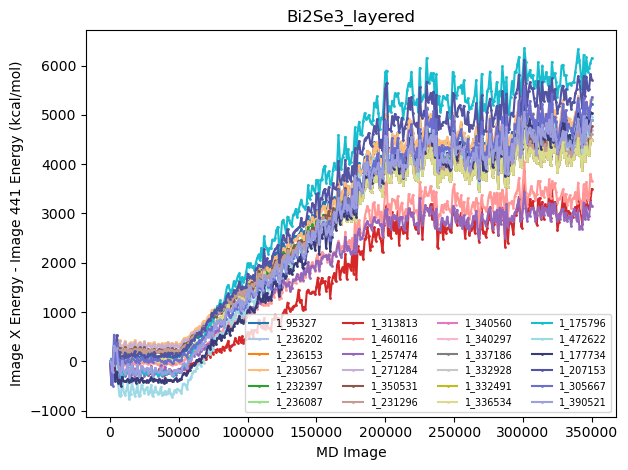

In [30]:
standard_deviation = False
md_image = 'Bi2Se3_layered' #'Bi2Se3_ortho' # 'Bi2Se3_layered'
normalize_image = 441 #92 # 441
x_string = 'MD Image'
all_y = f'Image X Energy - Image {normalize_image} Energy (kcal/mol)'
standard_deviation_y = f'Relative Energy Standard Deviation (kcal/mol)'
ignore = [0] # Ignore the first image before FF relaxation

if standard_deviation:
    y_string = standard_deviation_y
else:
    y_string = all_y

images_list, relative_energies_dct = plot_energy_dct(energy_dct, 
                md_image, 
                normalize_image, 
                x_string, 
                y_string,
                ignore=ignore,                                    
               standard_deviation=standard_deviation)

We observe that the variance in the energy predictions changes along the MD trajectory, and from trajectory to trajectory. This can provide us some guidance on which structures to sample for our DFT validation. 

## 9. Calculate the DFT single-point energies

For now, we won't use any complex sampling techniques, but instead perform DFT single point calculations on equally-spaced images along the MD trajectories, using the 0 image structure as our reference. We'll pull the structures at each image we sampled, evaluate them with DFT, and compare to the energies predicted by the force field ensemble. 

In [31]:
from pymatgen.io.lammps.data import LammpsData

def has_exact_number(path: str, number: int) -> bool:
    pattern = rf"(?<!\d){number}(?!\d)"
    return bool(re.search(pattern, path))

def get_structures(path, images):
    data = {}
    for root, _, _ in os.walk(path):
        for output_path in glob.glob(os.path.join(root, '*.lmp')):
            for image in images:
                if has_exact_number(output_path, image):
                    md = Path(output_path).parent.parent.name
                    structure = LammpsData.from_file(output_path, 
                                                     atom_style='charge').structure
                    nested_set(data, [md, image], {'structure': structure})
    return data

def write_structures(path, structure_dct):
    for md_run in structure_dct.keys():
        for image in structure_dct[md_run].keys():
            write_dir = os.path.join(path, md_run, str(image))
            os.makedirs(write_dir, exist_ok=True)
            write_path = os.path.join(write_dir, 'POSCAR')
            structure_dct[md_run][image]['structure'].to(write_path, fmt='poscar')
    return 

use_indices = np.linspace(0, len(images_list)-1, num=7) # Take 7 images
use_images = [images_list[int(i)] for i in use_indices]
use_images = use_images
structure_dct = get_structures(os.path.join(os.getcwd(), 'MD/single_point_runs/inputs_directory/Bi4Se3_layered'), 
              use_images)
#write_structures(os.path.join(os.getcwd(), 'DFT/new_runs/md_images'), structure_dct)

Now, we'll resubmit these new structures as single point DFT calculations. 

In [32]:
dft_md_dir = os.path.join(os.getcwd(), 'DFT/new_runs/') # path to vasp_submission script
dft_md_submission = 'submit_matsemble_vaspFlux_gpu.sh' # name of vasp_submission SLURM script
#MatEnsemble_submission_wrapper(workdir=dft_md_dir, 
#                               submission_file=dft_md_submission, 
#                               resubmit=True)

## 10. Determine the Best Force Field from the MD

We'll start by using parse2fit to parse and convert the VASP DFT energies (eV/atom) into (kcal/mol). 

In [33]:
from parse2fit.io.parsers import VaspParser
from parse2fit.tools.unitconverter import UnitConverter

In [34]:
def parse_VASP_energies(path, to_unit='kcal/mol'):
    uc = UnitConverter()
    data = {}
    for root, _, _ in os.walk(path):
        vasprun_path = os.path.join(root, 'vasprun.xml')
        if os.path.exists(vasprun_path): 
            try:
                energy = VaspParser(root).parse_energy()
                converted_energy = uc.convert(energy.value, energy.unit, to_unit, 'energy')
                image = int(Path(root).name)
                md = Path(root).parent.name
                nested_set(data, ['DFT', md, image], {'energy': converted_energy})
            except: 
                pass
    return data

In [35]:
vasp_energies = parse_VASP_energies(os.path.join(os.getcwd(), 'DFT/new_runs/md_images/'))

Let's update our ```energy_dct``` to include the VASP energies, converted into kcal/mol for compatibility, and plot the results. 

In [36]:
from copy import deepcopy

In [37]:
energy_dct_with_dft = deepcopy(energy_dct)
energy_dct_with_dft.update(vasp_energies)

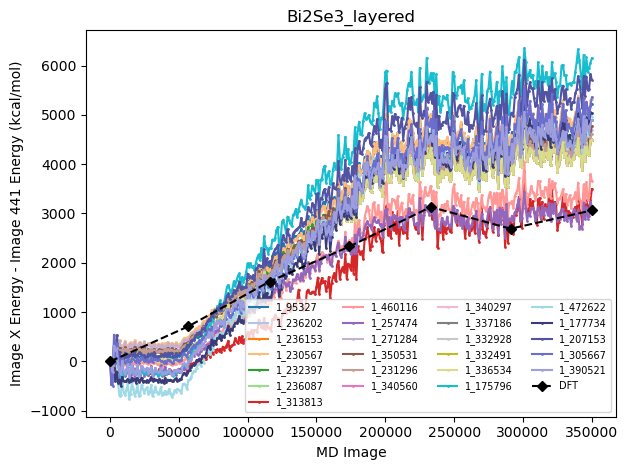

In [38]:
standard_deviation = False
x_string = 'MD Image'
all_y = f'Image X Energy - Image {normalize_image} Energy (kcal/mol)'
standard_deviation_y = f'Relative Energy Standard Deviation (kcal/mol)'

if standard_deviation:
    y_string = standard_deviation_y
else:
    y_string = all_y

images_list, relative_energies_dct = plot_energy_dct(energy_dct_with_dft, 
                md_image, 
                normalize_image, 
                x_string, 
                y_string,
                ignore=ignore,
               standard_deviation=standard_deviation)

It's likely that the force field used for MD runs isn't the best performer, based on the VASP validation! Let's write a quick function to rank performance by relative energy deviation from the DFT images, w.r.t. an image of our choice.  

In [39]:
def performance_rank(energy_dct, rel_image, check_MD):
    rank_dct = {}
    for ff in energy_dct.keys():
        rank_dct[ff] = {}
        diffs = []
        for dft_image in energy_dct['DFT'][check_MD].keys():
            
            rel_DFT = np.subtract(energy_dct['DFT'][check_MD][rel_image]['energy'], 
                               energy_dct['DFT'][check_MD][dft_image]['energy'])
            rel_FF = np.subtract(energy_dct[ff][check_MD][rel_image]['energy'], 
                               energy_dct[ff][check_MD][dft_image]['energy'])
            diff = np.subtract(rel_DFT, rel_FF)
            rank_dct[ff][dft_image] = diff
            diffs.append(diff)
        rmsd = np.sum(np.sqrt(np.square(diffs)))/len(diffs)
        rank_dct[ff]['RMSD'] = rmsd
    sorted_items = sorted(rank_dct.items(), key=lambda kv: kv[1]['RMSD'])
    for key, inner in sorted_items:
        print(f"{key}: RMSD = {inner['RMSD']}")
    return rank_dct, sorted_items

In [40]:
ranked_dct, sorted_items = performance_rank(energy_dct_with_dft, rel_image=normalize_image, check_MD=md_image)

DFT: RMSD = 0.0
1_257474: RMSD = 350.5850353183273
1_313813: RMSD = 417.35416031832665
1_460116: RMSD = 473.3077082628529
1_390521: RMSD = 777.3692725721962
1_236202: RMSD = 786.1447082628538
1_236153: RMSD = 786.1447082628538
1_236087: RMSD = 786.1447082628538
1_340560: RMSD = 786.1447082628538
1_340297: RMSD = 786.1447082628538
1_337186: RMSD = 786.1447082628538
1_332928: RMSD = 786.1447082628538
1_332491: RMSD = 786.1447082628538
1_336534: RMSD = 786.1447082628538
1_472622: RMSD = 873.7530225721957
1_271284: RMSD = 881.1756287161625
1_232397: RMSD = 887.8065037161673
1_231296: RMSD = 905.9105037161644
1_350531: RMSD = 920.9723787161652
1_305667: RMSD = 949.9469582628526
1_177734: RMSD = 989.0684582628528
1_95327: RMSD = 1135.7287537161665
1_230567: RMSD = 1138.604878716168
1_207153: RMSD = 1435.5958787161662
1_175796: RMSD = 1538.711378716166


Let's plot the top three performers vs. the force field that perform the MD, with respect to relative energy RMSD taken along randomly sampled images. 

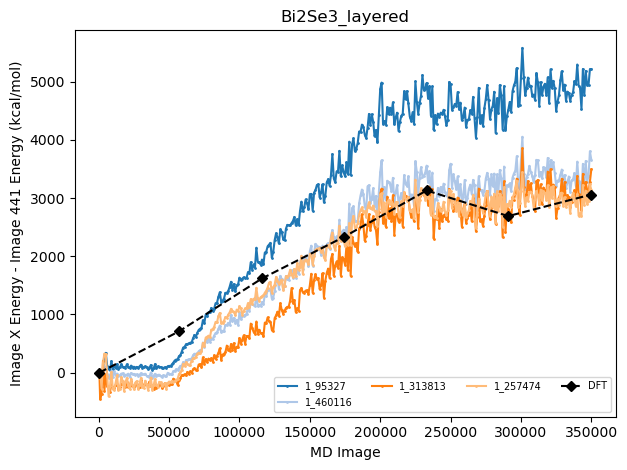

In [41]:
md_ff = '1_95327'
top_keys = [sorted_items[i][0] for i in range(0, 4)]  + [md_ff]
top_keys.reverse() # Take DFT and top 3 forcefields
top_dct = {}
for top_key in top_keys:
    top_dct[top_key] = energy_dct_with_dft[top_key]

single_images_list, single_relative_energies_dct = plot_energy_dct(top_dct, 
                md_image, 
                normalize_image, 
                x_string, 
                y_string,
                ignore=[0], 
               standard_deviation=standard_deviation)

## 11. Determine the Next Structures to Include in the Fit

In [42]:
def image_performance_rank(rank_dct):
    for ff_key in rank_dct.keys():
        print(f"{ff_key}")
        ff_dct = rank_dct[ff_key]
        sorted_items = sorted(ff_dct.items(), key=lambda kv: np.abs(kv[1]))     
        for key, inner in sorted_items:
            if key != 'RMSD':
                print(f"{key}: Deviation = {np.abs(inner)}")
        print('\n')
    return

In [43]:
top_ranked, top_results = performance_rank(top_dct, rel_image=normalize_image, check_MD=md_image)
image_performance_rank(top_ranked)

DFT: RMSD = 0.0
1_257474: RMSD = 350.5850353183273
1_313813: RMSD = 417.35416031832665
1_460116: RMSD = 473.3077082628529
1_95327: RMSD = 1135.7287537161665
1_95327
441: Deviation = 0.0
116000: Deviation = 325.0601818132527
57000: Deviation = 425.1230940816422
174000: Deviation = 1112.141191778108
0: Deviation = 1395.7452427626304
291000: Deviation = 1825.6908367851574
233000: Deviation = 1847.7350197849883
350000: Deviation = 2154.334462723553


1_460116
441: Deviation = 0.0
174000: Deviation = 126.04719177810694
116000: Deviation = 405.8478181867504
233000: Deviation = 426.41801978498916
291000: Deviation = 521.7548367851559
350000: Deviation = 595.3784627235509
57000: Deviation = 625.3300940816407
0: Deviation = 1085.685242762629


1_313813
441: Deviation = 0.0
233000: Deviation = 58.009019784989505
291000: Deviation = 119.96883678515587
174000: Deviation = 380.0148082218948
350000: Deviation = 433.02346272355135
0: Deviation = 569.7332427626279
57000: Deviation = 842.5060940816438


Let's view a structures that are consistently poorly predicted across the best performing force fields.

In [44]:
from pymatgen.core.structure import Structure

In [45]:
image = '57000'
print(image)
path = os.path.join(os.getcwd(), 'DFT/new_runs/md_images', md_image, str(image), 'POSCAR')
poor_structure = Structure.from_file(path)
view_structure(poor_structure, color_map)

57000


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In the case of ```Bi2Se3_layered/57000```, one of the vdW layer gaps has been significantly widened during NPT equilibration, which is likely an issue with the force field parameters. Adding this (or similar) structures back in to the dataset could be useful to improve the fitting.  

## Bonus: Compare Best ReaxFF to MACE Foundation Model

As a bonus, let's compare the predictions of our best performing force field, ```1_257474```, to the MACE foundation model from the Materials Project. We will need to have [pyMACE](https://anaconda.org/conda-forge/pymace) or the equivalent installed in our conda environment. 

In [46]:
valid_energy_dct = parse_single_points(os.path.join(os.getcwd(), 'MD/mace_comparison'))

Let's convert the kcal/mol energies to eV/atom, normalized by the number of atoms in the trajectory (360).

In [47]:
uc = UnitConverter()
eV_per_atom_valid_energy_dct = deepcopy(valid_energy_dct)
use_FFs = ['1_527979', '1_257474']
for ff_key in valid_energy_dct.keys():
    if ff_key in use_FFs:
        for md_key in valid_energy_dct[ff_key].keys():
            for image_key in valid_energy_dct[ff_key][md_key].keys():
                value = valid_energy_dct[ff_key][md_key][image_key]['energy']
                eV_per_atom_valid_energy_dct[ff_key][md_key][image_key]['energy'] = uc.convert(value, 'kcal/mol', 'eV', 'energy') / 360
    else:
       eV_per_atom_valid_energy_dct.pop(ff_key, 0) 

We can now parse the DFT energies for the trajectory, converting the integers back to strings in our json dictionary. 

In [48]:
import json
import re
from pathlib import Path
from typing import Any

_int_key_re = re.compile(r"^-?\d+$")   # matches optional leading '-' then digits only

def _convert_keys_to_int(obj: Any) -> Any:
    """
    Recursively convert dict keys that are integer strings into ints.
    - dict -> new dict with converted keys and recursively converted values
    - list -> new list with converted elements
    - other -> returned unchanged
    """
    if isinstance(obj, dict):
        new = {}
        for k, v in obj.items():
            # only attempt conversion for string keys that are pure integers
            if isinstance(k, str) and _int_key_re.fullmatch(k):
                new_key = int(k)
            else:
                new_key = k
            new[new_key] = _convert_keys_to_int(v)
        return new
    elif isinstance(obj, list):
        return [_convert_keys_to_int(x) for x in obj]
    else:
        return obj

def load_json_with_int_keys(path: str | Path) -> Any:
    """
    Load JSON from `path` and convert integer-like keys to ints recursively.
    """
    path = Path(path)
    with path.open("r") as fh:
        data = json.load(fh)
    return _convert_keys_to_int(data)

c_use_valid_vasp_energies = load_json_with_int_keys(os.path.join(os.getcwd(), 'DFT/mace_comparison/eV_per_atom_valid_energy_dct.json'))
eV_per_atom_valid_energy_dct.update(c_use_valid_vasp_energies)

Finally, let's parse the structures themselves, and perform single points with the small MACE foundation model before plotting to compare its energies to our new forcefield. 

In [49]:
from pymatgen.io.lammps.data import LammpsData
from pymatgen.io.ase import AseAtomsAdaptor

def get_atoms(path):
    atoms_dct = {}
    aaa = AseAtomsAdaptor()
    for root, _, _ in os.walk(path):
        structure_lmp = os.path.join(root, 'structure.lmp')
        if os.path.exists(structure_lmp):
            atoms = read(structure_lmp, format='lammps-data', atom_style='charge')
            label = int(Path(structure_lmp).parent.name)
            atoms_dct[label] = atoms
            
    return atoms_dct

In [50]:
atoms_dct = get_atoms(os.path.join(os.getcwd(), 'MD/mace_comparison/inputs_directory/4500_dump'))

In [51]:
import numpy as np
from ase import Atoms
from mace.calculators import mace_mp

mace_dct = {'MACE-MP-0 (small)': {'4500_dump': {}}} 
mace_model = mace_mp(model="small", device="cuda")
#calc = MACECalculator(foundation_model="MACE-MP-0", device="cuda")
for image, atoms in atoms_dct.items():
    atoms.set_calculator(mace_model)
    # Perform single-point evaluation
    e = atoms.get_potential_energy()
    mace_dct['MACE-MP-0 (small)']['4500_dump'][image] = {'energy': e / 360}

/global/homes/r/rym/.conda/envs/ensemblefffit/lib/python3.13/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


Using Materials Project MACE for MACECalculator with /global/homes/r/rym/.cache/mace/20231210mace128L0_energy_epoch249model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/global/homes/r/rym/.conda/envs/ensemblefffit/lib/python3.13/site-packages/mace/calculators/mace.py:143: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
Default dtype float32 does not match model dtype float64, converting models to float32.


/tmp/ipykernel_1028141/974734247.py:9: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(mace_model)


In [52]:
eV_per_atom_valid_energy_dct.update(mace_dct)

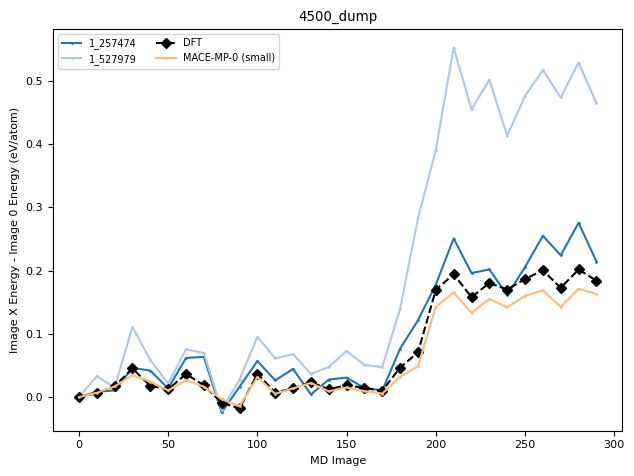

In [53]:
valid_index = 0
x_string = 'MD Image'
all_y = f'Image X Energy - Image {valid_index} Energy (eV/atom)'
valid_images_list, valid_relative_energies_dct = plot_energy_dct(eV_per_atom_valid_energy_dct, 
                '4500_dump', 
                valid_index, 
                x_string, 
                all_y,
                ignore=[], 
               standard_deviation=False, ncol=2, loc='upper left')

Wow! Our new force field is substantially better than the force field we started our fitting with (labeled ```1_527979```) on the validation trajectory! 